In [1]:
import json
import pandas as pd
from tqdm import tqdm
import networkx as nx
import matplotlib.pyplot as plt
import community as community_louvain
import numpy as np

In [2]:

data = []
rows_list = []
max_number_of_books = 100000
books = pd.DataFrame(data = data, columns=[
    'text_reviews_count', 'average_rating',
    'similar_books', 'authors', 'publisher',
    'num_pages', 'publication_year','book_id',
    'ratings_count', 'title'
])
count = 0
with open('goodreads_books.json',"r") as jsonfile:
    while True:
        if count >= max_number_of_books:
            break
        data = jsonfile.readline()
        if not data:
            break
        data = json.loads(data)
 
        try:
            text_reviews_count = int(data['text_reviews_count'])
            average_rating = float(data['average_rating'])
            publication_year = int(data['publication_year'])
            num_pages = int(data['num_pages'])
            ratings_count = int(data['ratings_count'])
            book_id = int(data['book_id'])
        except Exception:
            continue

        dict1 = {
        'text_reviews_count':text_reviews_count,
        'average_rating': average_rating,
        'similar_books': data['similar_books'],
        'authors': data['authors'],
        'publisher': data['publisher'],
        'num_pages': num_pages,
        'publication_year': publication_year,
        'book_id': book_id,
        'ratings_count': ratings_count,
        'title': data['title']
        }
        count +=1
        rows_list.append(dict1)

books = pd.DataFrame(rows_list)
print(books.head())

   text_reviews_count  average_rating  \
0                   1            4.00   
1                   7            4.03   
2                3282            3.49   
3                   7            4.13   
4                   6            4.22   

                                       similar_books  \
0                                                 []   
1  [19997, 828466, 1569323, 425389, 1176674, 2627...   
2  [6604176, 6054190, 2285777, 82641, 7569453, 70...   
3                                                 []   
4  [948696, 439885, 274955, 12978730, 372986, 216...   

                                  authors               publisher  num_pages  \
0   [{'author_id': '604031', 'role': ''}]      St. Martin's Press        256   
1    [{'author_id': '10333', 'role': ''}]  Nelson Doubleday, Inc.        600   
2     [{'author_id': '9212', 'role': ''}]             Atria Books        368   
3  [{'author_id': '3041852', 'role': ''}]    Yesterday's Classics        162   
4    [{'author_i

In [3]:
drop_list = ['text_reviews_count', 'average_rating', 'authors',
       'publisher', 'num_pages', 'publication_year',
       'ratings_count', 'title']
interaction_dataset = books.drop(columns=drop_list)
interaction_dataset

,similar_books,book_id
0,[],5333265
1,"[19997, 828466, 1569323, 425389, 1176674, 2627...",7327624
2,"[6604176, 6054190, 2285777, 82641, 7569453, 70...",6066819
3,[],287141
4,"[948696, 439885, 274955, 12978730, 372986, 216...",6066812
...,...,...
99995,[],3440164
99996,[],6310962
99997,"[125321, 90192, 937643, 42068, 78960, 866301, ...",8112400
99998,[],7055610


In [74]:
edge_list = []
single_nodes = 0
for i in tqdm(range(len(interaction_dataset))):
    source = interaction_dataset['book_id'][i]
    if len(interaction_dataset['similar_books'][i]) == 0:
        single_nodes += 1
    for destination in interaction_dataset['similar_books'][i]:
        edge_list.append((source, int(destination)))

G = nx.Graph()
N = 4000 # only process the first N samples
G.add_edges_from(edge_list[:N])

100%|███████████████████████████████████████████████████████████████████████| 100000/100000 [00:01<00:00, 67071.25it/s]


# Plot the Graph

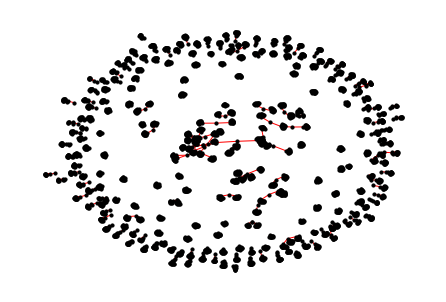

In [75]:
# Draw the graph without labels
nx.draw(G, node_size=10, node_color='black', edge_color='red')

# Display the plot
plt.show()

# Community detection

In [76]:
partition = community_louvain.best_partition(G)

In [77]:
pos = nx.spring_layout(G)  # Position nodes using Fruchterman-Reingold force-directed algorithm

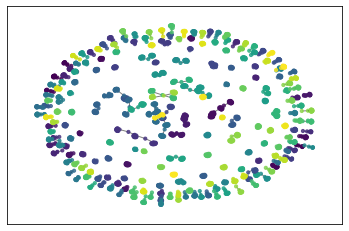

In [78]:
 # Position nodes using Fruchterman-Reingold force-directed algorithm
cmap = plt.get_cmap('viridis')
# Generate a color palette with a unique color for each community
colors = [cmap(float(i) / max(partition.values())) for i in partition.values()]

nx.draw_networkx_nodes(G, pos, node_color=colors, node_size=10, alpha=0.8)
nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5)

plt.show()

# Most Popular Author

In [79]:
# Calculate the degree of each node
degrees = G.degree()

# Sort nodes by degree in descending order and get the top N
N = 5
top_n_nodes = sorted(degrees, key=lambda x: x[1], reverse=True)[:N]

# Extract node IDs and their degrees
top_n_nodes_ids = [node[0] for node in top_n_nodes]
top_n_degrees = [node[1] for node in top_n_nodes]

print(f"Top {N} nodes with most connections: {top_n_nodes_ids}")
print(f"Degrees of top {N} nodes: {top_n_degrees}")

Top 5 nodes with most connections: [89377, 89378, 2008910, 12135833, 18628480]
Degrees of top 5 nodes: [18, 18, 18, 18, 18]


In [80]:
top_n_book_names = [books[books['book_id'] == i]['title'] for i in top_n_nodes_ids]

for i in range(len(top_n_book_names)):
    print(f"Rank {i+1} is: {top_n_book_names[i].item()}, with {top_n_degrees[i]} similar books")

Rank 1 is: Penny from Heaven, with 18 similar books
Rank 2 is: Dog Heaven, with 18 similar books
Rank 3 is: Buenos días, tristeza, with 18 similar books
Rank 4 is: Holding On, with 18 similar books
Rank 5 is: Stoner, with 18 similar books


# Best Author (Based on average rating)

In [90]:
authors = {}
authors_books = {}
authors_average_rating = {}

In [91]:
for i in range(len(books)):
    authors[int(books['authors'][i][0]['author_id'])] = []
    authors_books[int(books['authors'][i][0]['author_id'])] = []
    authors_average_rating[int(books['authors'][i][0]['author_id'])] = 0

In [92]:
for i in range(len(books)):
    authors[int(books['authors'][i][0]['author_id'])].append(books['average_rating'][i])
    authors_books[int(books['authors'][i][0]['author_id'])].append(books['title'][i])
    


In [93]:
for id in authors:
    temp_list = authors[id]
    authors_average_rating[id] = sum(temp_list) / len(temp_list)

In [94]:
sorted_dict = dict(sorted(authors_average_rating.items(), key=lambda item: item[1]))

# The top N authors
top_n = 10

# Get the last n values from the dictionary
last_n_values = dict(list(sorted_dict.items())[-top_n:])

# Print the last n values
print(last_n_values)

{105737: 5.0, 7156864: 5.0, 8446312: 5.0, 7302232: 5.0, 403091: 5.0, 3175525: 5.0, 4177143: 5.0, 4985369: 5.0, 4656251: 5.0, 88017: 5.0}


In [101]:
for author_id in last_n_values:
    books_list = authors[author_id]
    print(f"Author ID: {author_id}, with average book rating of {last_n_values[author_id]}, has written")
    for book_title in authors_books[author_id]:
        print(book_title)

Author ID: 105737, with average book rating of 5.0, has written
Test of Faith: A Novel of Faith and Murder in the Southwest
Author ID: 7156864, with average book rating of 5.0, has written
Just a Vampire
Author ID: 8446312, with average book rating of 5.0, has written
Folie(s), 18 textes échappés de l'asile
Author ID: 7302232, with average book rating of 5.0, has written
ما وراء باب الحقيقة
Author ID: 403091, with average book rating of 5.0, has written
The Native American Curio Trade In New Mexico
Author ID: 3175525, with average book rating of 5.0, has written
Eden At Play: A Grown-Up Fable
Author ID: 4177143, with average book rating of 5.0, has written
You Have the Power!
Author ID: 4985369, with average book rating of 5.0, has written
The Devildogs of Old Sauk Trail: And Other Tales of Hope & Horror
Author ID: 4656251, with average book rating of 5.0, has written
Drum Machine
Author ID: 88017, with average book rating of 5.0, has written
Dragon Magazine #189
